### ML Privacy Meter (white-box) membership inference attack

In [1]:
import os
from IPython.display import display, Image

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

import ml_privacy_meter

2022-02-08 13:39:24.518370: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 13:39:24.524698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 13:39:24.525044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Create datasets

In [2]:
n_classes = 2
n_features = 300

# (X,y): Original distribution
X, y = make_classification(
    n_samples=1000,
    n_classes=n_classes,
    n_features=n_features,
    n_informative=n_features,
    n_redundant=0,
    n_repeated=0,
    random_state=15,
)
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(
    n_samples=1000,
    n_classes=n_classes,
    n_features=n_features,
    n_informative=n_features,
    n_redundant=0,
    n_repeated=0,
    random_state=42,
)
yd = np.eye(n_classes)[yd]

### Train target model

In [3]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(
    Xt, yt, test_size=0.5, shuffle=False
)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8),
    )
).flatten()

# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)


def get_model():
    input_data = Input(shape=Xt_member[0].shape)
    x = Dense(128, activation="relu")(input_data)
    x = Dense(128, activation="relu")(x)
    x = Dense(64, activation="relu")(x)
    output = Dense(2, activation="softmax")(x)
    model = Model(input_data, output)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


# Train target model
target_model = get_model()
r = target_model.fit(
    Xt_member,
    yt_member,
    validation_data=(Xt_nonmember, yt_nonmember),
    epochs=10,
    batch_size=32,
)

2022-02-08 13:39:24.995877: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 13:39:24.996473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 13:39:24.997113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-08 13:39:24.997631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/10
8/8 [==============================] - 1s 22ms/step - loss: 1.8973 - accuracy: 0.5160 - val_loss: 1.4647 - val_accuracy: 0.5800
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.2200 - accuracy: 0.9360 - val_loss: 1.2266 - val_accuracy: 0.6160
Epoch 3/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0375 - accuracy: 0.9960 - val_loss: 1.1214 - val_accuracy: 0.6400
Epoch 4/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 1.0981 - val_accuracy: 0.6400
Epoch 5/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.0968 - val_accuracy: 0.6400
Epoch 6/10
8/8 [==============================] - 0s 6ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.1027 - val_accuracy: 0.6520
Epoch 7/10
8/8 [==============================] - 0s 7ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.1079 - val_accuracy: 0.6600
Epoch 8/10
8/8 [=================

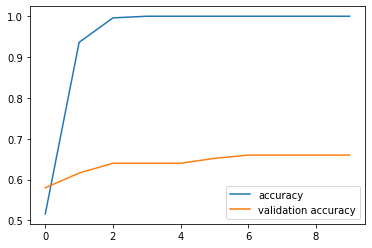

In [4]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

### ML Privacy Meter attack

#### Convert data to the requisite format

In [5]:
def to_str(A, B):
    s = ""
    for i in range(len(A)):
        s += f"{A[i][0]}"
        for j in range(1, len(A[0])):
            s += f",{A[i][j]}"
        s += f";{np.argmax(B[i])}\n"
    return s


with open("Xt_nonmember.txt", "wt") as f:
    f.write(to_str(Xt_nonmember, yt_nonmember))

with open("Xt_member.txt", "wt") as f:
    f.write(to_str(Xt_member, yt_member))

with open("Xt_member.txt", "r") as f:
    dataset = f.readlines()
dataset = map(lambda i: i.strip("\n").split(";"), dataset)
dataset = np.array(list(dataset))
np.save("Xt_member.txt.npy", dataset)

#### Run white-box attack

In [6]:
saved_path = "Xt_member.txt.npy"  # memberset
dataset_path = "Xt_nonmember.txt"  # non-memberset

cmodelA = target_model

datahandlerA = ml_privacy_meter.utils.attack_data.attack_data(
    dataset_path=dataset_path,
    member_dataset_path=saved_path,
    batch_size=64,
    attack_percentage=50,
    input_shape=(n_features,),
)

attackobj = ml_privacy_meter.attack.meminf.initialize(
    target_train_model=cmodelA,
    target_attack_model=cmodelA,
    learning_rate=0.0001,
    optimizer="adam",
    train_datahandler=datahandlerA,
    attack_datahandler=datahandlerA,
    layers_to_exploit=[4],
    gradients_to_exploit=[2, 3, 4],
)
attackobj.train_attack()


Target model test accuracy 0.648


/home/unknown/ml_privacy_meter/ml_privacy_meter/utils/attack_utils.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  hashval = hash(bytes(np.array(example)))
/home/unknown/ml_privacy_meter/ml_privacy_meter/utils/attack_utils.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  hashval = hash(bytes(np.array(example)))
/home/unknown/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or

Epoch 0 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 1 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 2 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 3 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 4 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 5 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 6 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 7 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 8 over :Attack test accuracy: 0.5, Best accuracy : 0.5
Epoch 9 over :Attack test accuracy: 0.5360000133514404, Best accuracy : 0.5360000133514404
Epoch 10 over :Attack test accuracy: 0.5320000052452087, Best accuracy : 0.5360000133514404
Epoch 11 over :Attack test accuracy: 0.527999997138977, Best accuracy : 0.5360000133514404
Epoch 12 over :Attack test accuracy: 0.5400000214576721, Best accuracy : 0.5400000214576721
Epoch 13 over :Attack test accuracy: 0.5920000076293945, Best accuracy : 0.5920000076

Epoch 93 over :Attack test accuracy: 0.8560000061988831, Best accuracy : 0.9039999842643738
Epoch 94 over :Attack test accuracy: 0.8560000061988831, Best accuracy : 0.9039999842643738
Epoch 95 over :Attack test accuracy: 0.8560000061988831, Best accuracy : 0.9039999842643738
Epoch 96 over :Attack test accuracy: 0.8560000061988831, Best accuracy : 0.9039999842643738
Epoch 97 over :Attack test accuracy: 0.8519999980926514, Best accuracy : 0.9039999842643738
Epoch 98 over :Attack test accuracy: 0.8519999980926514, Best accuracy : 0.9039999842643738
Epoch 99 over :Attack test accuracy: 0.8519999980926514, Best accuracy : 0.9039999842643738


2022-02-08 13:43:10.226767: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-08 13:43:10.226839: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-08 13:43:10.428541: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-08 13:43:10.428617: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

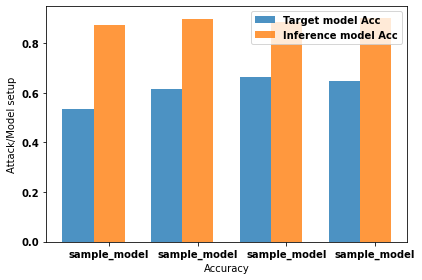

In [7]:
attackobj.test_attack()

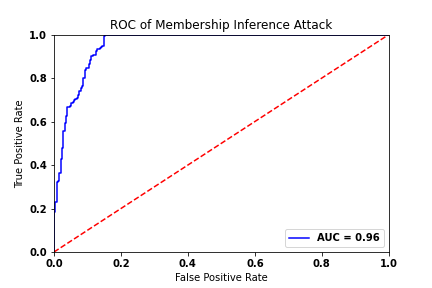

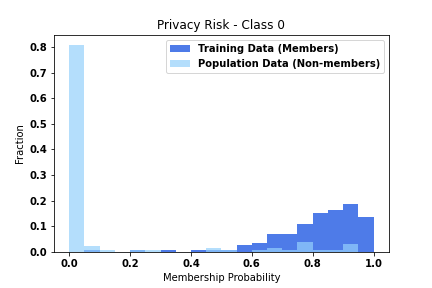

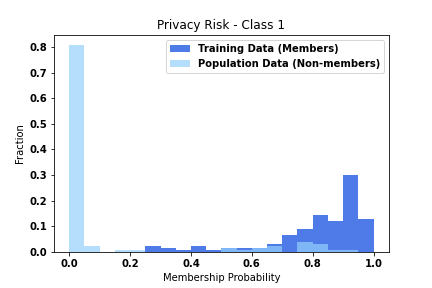

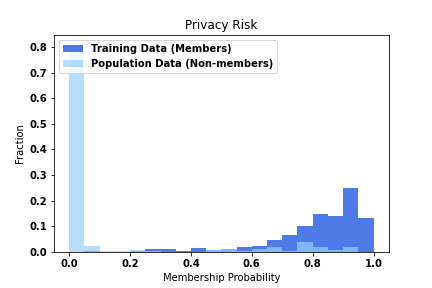

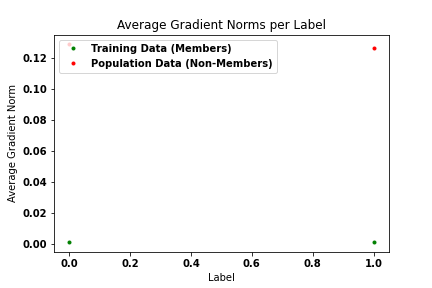

In [8]:
PLOT_PATH = os.path.normpath("logs/plots/")

for filename in os.listdir(PLOT_PATH):
    path = os.path.join(PLOT_PATH, filename)
    display(Image(path))